# Running the CUES SUMMA setup

Before running this notebook, make sure you have the CUES site installed (see `install_summa_model_configurations.ipynb`).

In [1]:
%pylab inline
import pysumma as ps
import xarray as xr

Populating the interactive namespace from numpy and matplotlib


<br>

## Instantiating a simulation object

To set up a `Simulation` object you must supply 2 pieces of information. 

First, the SUMMA executable; this could be either the compiled executable on your local machine, or a docker image. 
For this case, I'll assume that `summa.exe` is on your path. 
See the commented out `executable` for example of how you could also define the docker image. 
The string for the docker image simply came from looking at the output of the `docker images` command.

The second piece of information is the path to the file manager, which we just created through the install script.
To create the `Simulation` object you can then just pass these to the constructor as shown below.

In [2]:
executable = 'summa.exe'
file_manager = '/home/jovyan/data/cues/summa_setup/settings/file_manager_cues.txt'

s = ps.Simulation(executable, file_manager)

<br>

## Manipulating the configuration of the simulation object

Most of your interactions with pysumma will be facilitated through this `Simulation` object, so let's take some time to look through what is in it. 
What's contained in the `Simulation` object right after instantiation is generally just the input required for a SUMMA run.
For a more in depth discussion of what these are see the [SUMMA Input](https://summa.readthedocs.io/en/latest/input_output/SUMMA_input/) page of the documentation.
There are several attributes of interest that can be examined. 
To see each of them you can simply `print` them. 
Here's a very high level overview of what's available:

* `s.manager` - the file manager
* `s.decisions` - the decisions file
* `s.output_control` - defines what variables to write out
* `s.force_file_list` - a listing of all of the forcing files to use
* `s.local_attributes` - describes GRU/HRU attributes (lat, lon, elevation, etc)
* `s.local_param_info` - listing of spatially constant local (HRU) parameter values
* `s.basin_param_info` - listing of spatially constant basin (GRU) parameter values
* `s.parameter_trial` - spatially distributed parameter values (will overwrite `local_param_info` values, can be either HRU or GRU)

Most of these objects have a similar interface defined, with exceptions being `local_attributes` and `parameter_trial`. Those two are standard `xarray` datasets. All others follow the simple API:

```
print(x)                   # Show the data as SUMMA reads it
x.get_option(NAME)         # Get an option
x.set_option(NAME, VALUE)  # Change an option
x.remove_option(NAME)      # Remove an option
```

More intuitively, you can use `key` - `value` type indexing like dictionaries, dataframes, and datasets:

```
print(x['key'])    # Get an option
x['key'] = value   # Change an option
```

### Setting decisions

So, now that we've got a handle on what's available and what you can do with it, let's actually try some of this out. First let's just print out our decisions file so we can see what's in the defaults.


In [3]:
print(s.decisions)

soilCatTbl    ROSETTA              ! soil-category dataset
vegeParTbl    MODIFIED_IGBP_MODIS_NOAH ! vegetation-category dataset
soilStress    NoahType             ! choice of function for the soil moisture control on stomatal resistance
stomResist    BallBerry            ! choice of function for stomatal resistance
num_method    itertive             ! choice of numerical method
fDerivMeth    analytic             ! choice of method to calculate flux derivatives
LAI_method    monTable             ! choice of method to determine LAI and SAI
f_Richards    mixdform             ! form of Richards equation
groundwatr    qTopmodl             ! choice of groundwater parameterization
hc_profile    pow_prof             ! choice of hydraulic conductivity profile
bcUpprTdyn    nrg_flux             ! type of upper boundary condition for thermodynamics
bcLowrTdyn    zeroFlux             ! type of lower boundary condition for thermodynamics
bcUpprSoiH    liq_flux             ! type of upper boundary c

<br> 

Great, we can see what's in there. But to be able to change anything we need to know the available options for each decision. Let's look at how to do that. For arbitrary reasons we will look at the `snowIncept` option, which describes the parameterization for snow interception in the canopy. First we will get it from the `decisions` object directly, and then query what it can be changed to, then finally change the value to something else.

<br>

In [4]:
# Get just the `snowIncept` option
print(s.decisions['snowIncept'])

# Look at what we can set it to
print(s.decisions['snowIncept'].available_options)

# Change the value 
s.decisions['snowIncept'] = 'stickySnow'
print(s.decisions['snowIncept'])

snowIncept    lightSnow            ! choice of parameterization for snow interception
['stickySnow', 'lightSnow']
snowIncept    stickySnow           ! choice of parameterization for snow interception


<br>

### Changing parameters

Much like the decisions we can manipulate the `local_param_info` file. First, let's look at what's contained in it

In [5]:
print(s.global_hru_params)

upperBoundHead            |      -7.5d-1 |      -1.0d+2 |      -1.0d-2
lowerBoundHead            |      -1.0d+1 |      -1.0d+2 |      -1.0d-2
upperBoundTheta           |       0.2004 |       0.1020 |       0.3680
lowerBoundTheta           |       0.1100 |       0.1020 |       0.3680
upperBoundTemp            |     272.1600 |     270.1600 |     280.1600
lowerBoundTemp            |     274.1600 |     270.1600 |     280.1600
tempCritRain              |     273.1600 |     272.1600 |     274.1600
tempRangeTimestep         |       2.0000 |       0.5000 |       5.0000
frozenPrecipMultip        |       1.0000 |       0.5000 |       1.5000
snowfrz_scale             |      50.0000 |      10.0000 |    1000.0000
fixedThermalCond_snow     |       0.3500 |       0.1000 |       1.0000
albedoMax                 |       0.8400 |       0.7000 |       0.9500
albedoMinWinter           |       0.5500 |       0.6000 |       1.0000
albedoMinSpring           |       0.5500 |       0.3000 |       1.0000
albedo

<br>

<br>

Yikes, that's pretty long. Okay but we can change things. See:

In [6]:
# Print it
print(s.global_hru_params['albedoMax'])

# Change the value
s.global_hru_params['albedoMax'] = 0.9
print(s.global_hru_params['albedoMax'])

albedoMax                 |       0.8400 |       0.7000 |       0.9500
albedoMax                 |       0.9000 |       0.9000 |       0.9000


<br>

### Modifying output
And one more, we can also modify what get's written to output. 
The output control file represents the options available through columns of numeric values.
These numbers represent how to write the output. 
From the SUMMA documentation they are arranged as:

```
! varName          | outFreq | inst | sum | mean | var | min | max | mode
```

As before, let's look at what's in the `output_control` by simply printing it out.

<br>

In [7]:
print(s.output_control)

pptrate                              | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
airtemp                              | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarRainPlusMelt                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSWE                            | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarThroughfallSnow                | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarThroughfallRain                | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSnowSublimation                | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarInfiltration                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarExfiltration                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSurfaceRunoff                  | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSurfaceTemp                    | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSenHeatTotal                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarLatHeatTotal                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
averageInstantRunoff                 | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
averageRoutedRunoff               

<br>

Then, we can modify values in a couple of ways.

<br>

In [8]:
# Just change the frequency to daily output
print(s.output_control['scalarNetRadiation'])
print(s.output_control['scalarNetRadiation'].statistic)

# Change the output statistic from instantaneous to sum
s.output_control['scalarNetRadiation'] = [1, 1, 0, 0, 0, 0, 0, 0]
s.output_control['scalarSnowAge'] = [1, 1, 0, 0, 0, 0, 0, 0]
print(s.output_control['scalarNetRadiation'])
print(s.output_control['scalarNetRadiation'].statistic)

# We could also be more verbose:
s.output_control['scalarNetRadiation'] = {
    'period': 1, 'instant': 1, 'sum': 0, 
    'mean': 0, 'variance': 0, 'min': 0, 'max': 0
}
print(s.output_control['scalarNetRadiation'])
print(s.output_control['scalarNetRadiation'].statistic)

scalarNetRadiation                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
instant
scalarNetRadiation                   | 1 | 1 | 0 | 0 | 0 | 0 | 0 | 0
sum
scalarNetRadiation                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
instant


<br>

## Running pysumma and manipulating output

Now that you've had an overview of how you can interact with SUMMA configurations through pysumma let's run a simulation. 
Before doing so we will reset our `Simulation` object, which will discard all of the changes we've made and load in a clean setup. 
Alternatively you could simply instantiate a new `Simulation` object.
We will also modify the start and finish times of the simulation to speed things up, as well as add a few more variables to the output to demonstrate some plotting capabilities
After running the simulation, we will make sure that it completed successfully by checking the status.
With a complete run, we can look at the output simply by using the simulation's `output` attribute.
It is simply an xarray dataset, which can be manipulated in all of the usual ways.

In [9]:
s.reset()
# Or you could just create a new simulation object like before:
#s = ps.Simulation(executable, file_manager)

# Shorten the simulation length
s.manager['simStartTime'] = '2010-10-01 00:00'
s.manager['simEndTime'] = '2012-10-01 00:00'

# Add in some additional variables so we can demonstrate plotting capabilities
output_settings = {'period': 1, 'instant': 1, 'sum': 0, 
              'mean': 0, 'variance': 0, 'min': 0, 'max': 0}
layer_vars = ['mLayerTemp', 'mLayerDepth', 'mLayerHeight',
              'mLayerLiqFluxSoil', 'mLayerVolFracIce', 'mLayerVolFracLiq', 
              'mLayerVolFracWat','mLayerMatricHead', 'iLayerHeight', 'scalarSnowDepth']

# Create the new variables
for var in layer_vars:
    s.output_control[var] = output_settings

# Ensure all variables have the same statistics
all_vars = set(layer_vars + [o.name for o in s.output_control.options])
for var in all_vars:
    s.output_control[var] = output_settings

In [10]:
s.run('local', run_suffix='_default')
print(s.status)

Success


You should have gotten a `'Success'` printed out after running the simulation. For further details about the simulation you can look at the full output log that SUMMA produces by printing out `s.stdout`. In the event that `s.status` does not return `Success` you may wish to inspect this log to diagnose the problem further.

<br>

## Plotting

Now that we've got some output we can plot some results. Because the output is an xarray `DataSet` we can use the convenient plotting capabilities provided by xarray.

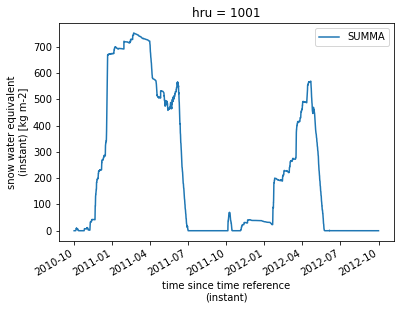

In [11]:
s.output['scalarSWE'].plot(label='SUMMA')
plt.legend()

<br>

Additionally, pysumma provides some more specialized plotting capabilitieswe. To access it we have the `ps.plotting` module. First, lets plot the vertical layers over time. For this we will use `ps.plotting.layers`, which requires two pieces of information. First, the variable that you want to plot. It should have both `time` and `midToto` dimensions. The first plot we will make will be the temperature, which uses the variable `mLayerTemp`, and the second will be the volumetric fraction of water content in each layer, which uses `mLayerVolFracWat`. To start out we will give these more convenient names.


In [12]:
depth = s.output.isel(hru=0)['iLayerHeight']
temp = s.output.isel(hru=0)['mLayerTemp']
frac_wat = s.output.isel(hru=0)['mLayerVolFracWat']

Now we can plot this using our function. For the temperature plot we will set `plot_soil` to `False` so that we only plot the snowpack. We can see that the top layers of the snowpack respond more quickly to the changing air temperature, and that later in the season the warmer air causes temperature transmission to lower layers and ultimately melts out. 

In [13]:
import pysumma.plotting as psp

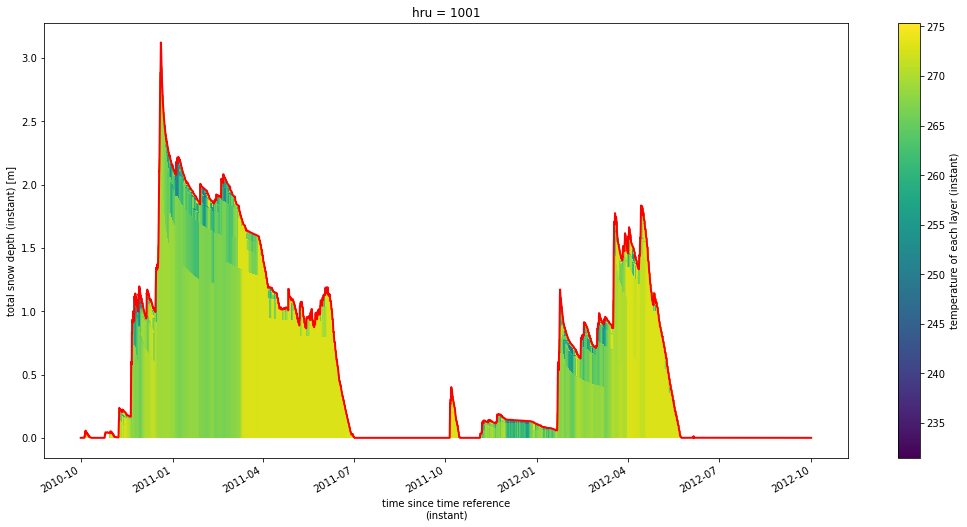

In [14]:
psp.layers(temp, depth, colormap='viridis', plot_soil=False, plot_snow=True)
s.output['scalarSnowDepth'].plot(color='red', linewidth=2)

By looking at the volumetric water content we can see even more details. Now we will set `plot_soil` to `True` so that we can see how snowmelt can cause water infiltration into the soil. For example, during the melt season in 2012 we can easily see how the snowmelt infiltrates into the ground.

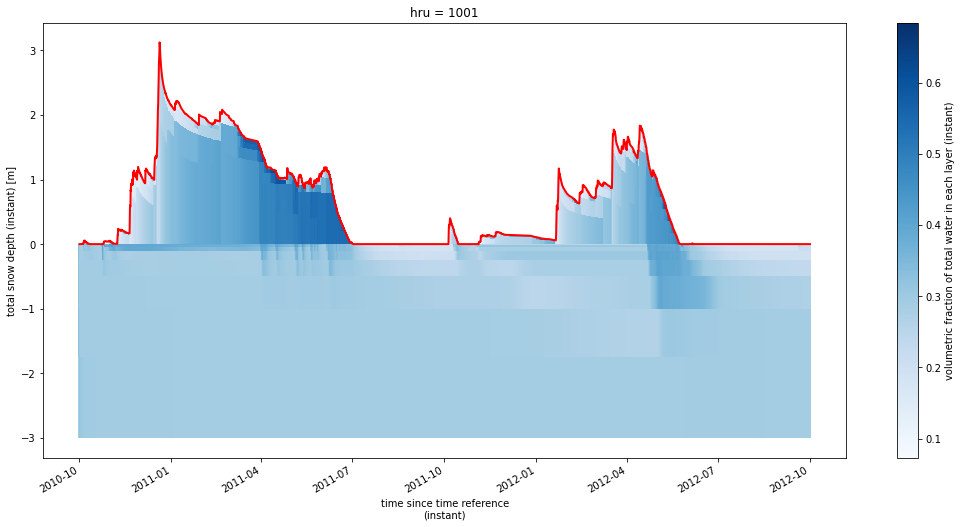

In [15]:
psp.layers(frac_wat, depth, colormap='Blues', plot_soil=True, plot_snow=True)
s.output['scalarSnowDepth'].plot(color='red', linewidth=2)

<br>

Next, we will demonstrate the `ps.plotting.hovmoller` functionality. It allows us to see how a variable varies along different axes. For our example we will look at how the surface temperature varies across our of day and month of year. We can see both seasonal and diurnal trends.  Temperature peaks tend to occur during summer months in the early afternoon. The available options for time aggregation include `year`, `month`, `day`, `hour`, `dayofyear`, `week`, `dayofweek`, `weekday`, and `quarter`. For spatially distributed runs the `hovmoller` function can also aggregate over `latitude` and `longitude`.

False True False True


/opt/conda/lib/python3.8/site-packages/pysumma/plotting/hovmoller.py:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.axes.pcolormesh(x, y, z, cmap=cmap)


Text(0.5, 1.0, 'Surface Temperature (K)')

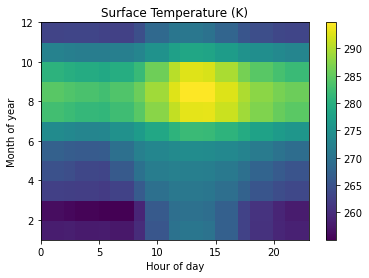

In [16]:
fig, ax = psp.hovmoller(s.output['scalarSurfaceTemp'].isel(hru=0), xdim='hour', ydim='month')
ax.set_xlabel('Hour of day')
ax.set_ylabel('Month of year')
ax.set_title('Surface Temperature (K)')